# Anderson model of localization

## initializations

In [1]:
#standard notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#standard libraries
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

import random as rn
import os
import matplotlib.pyplot as plt
#np.random.seed(1337) # for reproducibility
#np.random.seed(2000) 

In [3]:
#machine learning libraries
import tensorflow as tf 
import keras
print("tensorflow: ",tf.__version__, ", keras: ", keras.__version__)

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
print("sklearn: ", sklearn.__version__)

Using TensorFlow backend.


tensorflow:  2.0.0 , keras:  2.3.1
sklearn:  0.21.3


In [4]:
#special subroutines
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, Flatten
from keras.layers import Dropout
from keras import optimizers
from keras.models import load_model

# from tensorflow.keras.layers import Dense, Conv2D
# from tensorflow.keras.layers import Conv1D, MaxPooling2D
# from tensorflow.keras.layers import AveragePooling2D, Flatten
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.models import Sequential


# from tensorflow.keras.utils import to_categorical

# import numpy

## starting the main code

In [5]:
myseed = 123467

np.random.seed(myseed) # necessary for starting Numpy generated random numbers in a well-defined initial state.
rn.seed(myseed+1) # necessary for starting core Python generated random numbers in a well-defined state.

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

os.environ['PYTHONHASHSEED'] = '0'

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from tensorflow.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.compat.v2.random.set_seed(myseed+3)
#tf.set_random_seed(1234)

#sess = tf.compat.v2.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

## reading the images

In [6]:
img_sizeX= 171
img_sizeY= 193 #img_sizeX
validation_split= 0.1

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,validation_split=validation_split)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 16
dataname = 'data-L20-500-CO-NF'
datapath = '../'+dataname
modelname = '/model_'+dataname+'.h5'
modelpath = datapath+modelname

In [8]:
training_set = train_datagen.flow_from_directory(datapath,
                                                 subset='training',
                                                 target_size = (img_sizeX,img_sizeY),
                                                 batch_size = batch_size, 
                                                 class_mode='categorical',
                                                shuffle=True,seed=myseed)

validation_set= train_datagen.flow_from_directory(datapath, 
                                              subset='validation', 
                                              target_size = (img_sizeX,img_sizeY),
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                                 shuffle=False,seed=myseed)

# test_set = test_datagen.flow_from_directory('data-keras-L20-100/test_set',
#                                             target_size = (171, 171),
#                                             batch_size = batch_size,
#                                             class_mode='categorical',
#                                            shuffle=False)

Found 7650 images belonging to 17 classes.
Found 850 images belonging to 17 classes.


In [9]:
# X_train, X_labels = next(training_set)
# Y_train, Y_labels = next(validation_set)
# len(X_train),len(X_labels),len(Y_train),len(Y_labels)

In [10]:
num_of_train_samples = training_set.samples
num_of_test_samples = validation_set.samples
num_classes = len(validation_set.class_indices)

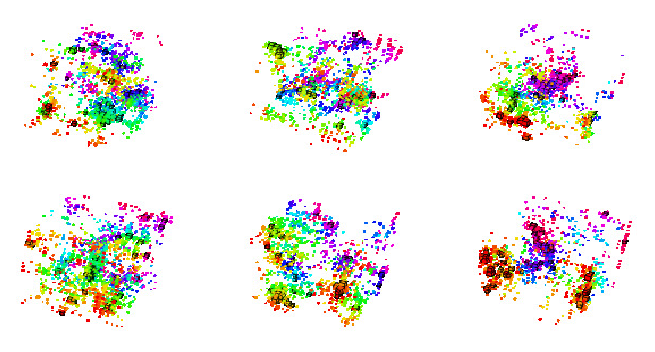

In [11]:
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in validation_set:
        plt.imshow(x[0],cmap='hsv')
        #plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

## building the CNN

In [12]:
def create_CNN():
    # instantiate model
    model=Sequential()

    model.add(Conv2D(16, kernel_size=(5,5),input_shape=(img_sizeX, img_sizeY, 3),
                     activation = 'relu',  padding='valid'))
    model.add(Conv2D(16, kernel_size=(5,5),activation = 'relu',padding='same'))
    
    model.add(MaxPooling2D(pool_size =(2, 2), padding='same'))

    model.add(Dropout(0.5))
               
    model.add(Conv2D(32,kernel_size=(3,3), activation = 'relu', padding='valid'))  
    model.add(Conv2D(32,kernel_size=(3,3), activation = 'relu', padding='same')) 
                 
    model.add(MaxPooling2D(pool_size =(2, 2),padding='same')) 
    
    model.add(Dropout(0.5))

    model.add(Conv2D(64, kernel_size=(5,5), activation = 'relu',  padding='valid'))
    model.add(Conv2D(64, kernel_size=(5,5),activation = 'relu',padding='same'))
    model.add(MaxPooling2D(pool_size =(2, 2),padding='same'))
                  
    model.add(Dropout(0.5))

    model.add(Flatten())
                             
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = num_classes, activation = 'softmax')) 
    
    return model

print('CNN architecture (Ohtsuki) created successfully!')

CNN architecture (Ohtsuki) created successfully!


In [13]:
mylr=0.01
mywd=1e-6

# Choose the Optimizer and the Cost Function

opt = optimizers.SGD(lr=mylr, decay=mywd)
#opt = keras.optimizers.Adam(lr=mylr, decay=mywd)

def compile_model(optimizer=opt):
    # create the mode
    model=create_CNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


In [14]:
# opt = optimizers.SGD(lr=mylr, decay=mywd)
# model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# create the deep neural net
model = compile_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 167, 189, 16)      1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 167, 189, 16)      6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 84, 95, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 84, 95, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 82, 93, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 82, 93, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 47, 32)       

## learning the images

In [15]:
# training parameters
myepochs=10

In [16]:
# train DNN and store training info in history
#history = model.fit_generator(training_set,
#                         steps_per_epoch = training_set.samples // batch_size,
#                         epochs = myepochs,
#                         validation_data = validation_set,
#                         validation_steps = validation_set.samples // batch_size)

In [17]:
# tf.keras.models.save_model(history,'Anderson_Ohtsuki_model_L20_500_keras_SGD_0_01_good_input_size.h5') 
#model.save(modelpath) 

## testing the quality of the learned model

In [18]:
from tensorflow.keras.models import load_model
model=load_model(modelpath)

history = load_model(modelpath)

In [19]:
# evaluate model
score=model.evaluate(validation_set,verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
fig=plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(datapath+'/'+dataname+'_accuracy'+'.png')

# summarize history for loss
fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(datapath+'/'+dataname+'_loss'+'.png')

54/54 [==============================] - 15s 271ms/step - loss: 2.8325 - accuracy: 0.0588

Test loss: 2.8324974554556386
Test accuracy: 0.05882353


AttributeError: 'Sequential' object has no attribute 'history'

<Figure size 432x288 with 0 Axes>

In [ ]:
validation_set.reset()
label=validation_set.class_indices.keys()

#Confusion Matrix 
Y_pred = model.predict_generator(validation_set, num_of_test_samples // batch_size+1, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

#basic confusion matrix
confusion_matrix(validation_set.classes, y_pred)

In [ ]:
os.chdir('../PyCode/')
from plot_confusion_matrix import *

print(plot_confusion_matrix(confusion_matrix(validation_set.classes, y_pred),
                          label,
                          title='Confusion matrix for '+dataname,
                          cmap=None,
                          normalize=True))
os.chdir('../src/')

## modify the Hyperparameters to Optimize Performance of the Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
X_train, X_labels = next(training_set)
Y_train, Y_labels = next(validation_set)
len(X_train),len(X_labels),len(Y_train),len(Y_labels)

In [ ]:
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=1, 
                        batch_size=batch_size, 
                        verbose=1)

# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# define parameter dictionary
param_grid = dict(optimizer=optimizer)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(X_train,Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))